## Preambule

In [410]:
import numpy as np
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Run classes

Data reader class

In [ ]:
import class_datareading
reload(class_datareading)
from class_datareading import datareading

datareader = datareading()
datareader.read_general()
datareader.read_ssps()
datareader.read_undata()
datareader.read_hdi()
datareader.read_historicalemis_jones()
datareader.read_ar6()
datareader.relation_budget_nonco2()
datareader.determine_global_nonco2_trajectories()
datareader.determine_global_budgets()
datareader.determine_global_co2_trajectories()
datareader.read_baseline()
datareader.read_ndc()
datareader.merge_xr()
datareader.add_country_groups()
datareader.save()
datareader.country_specific_datareaders()

# ==================================== #
# DATAREADING class                    #
# startyear:  2021
# ==================================== #
- Reading general data
- Reading GDP and population data from SSPs


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000021C6F02B200>>
Traceback (most recent call last):
  File "C:\Users\dekkerm\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "k:\Environments\MyEnv\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


- Reading UN population data and gapminder, processed by OWID (for past population)
- Read Human Development Index data
- Reading historical emissions (jones)
- Read AR6 data
- Get relationship between CO2 budgets and non-co2 reduction in 2050
- Computing global nonco2 trajectories
- Get global CO2 budgets
- Computing global co2 trajectories


In [411]:
import class_allocation
reload(class_allocation)
from class_allocation import allocation

allocator = allocation("IND", lulucf='incl', gas='GHG')
allocator.gf()
allocator.pc()
allocator.pcc()
allocator.pcb()
allocator.ecpc()
allocator.ap()
allocator.gdr()
allocator.save()

MemoryError: Unable to allocate 1.35 GiB for an array with shape (7, 5, 10, 5, 2, 251, 207) and data type float64

In [ ]:
self.xr_alloc.ECPC

Text(0.5, 1.0, 'T = 1.6 , Conv year = 2080')

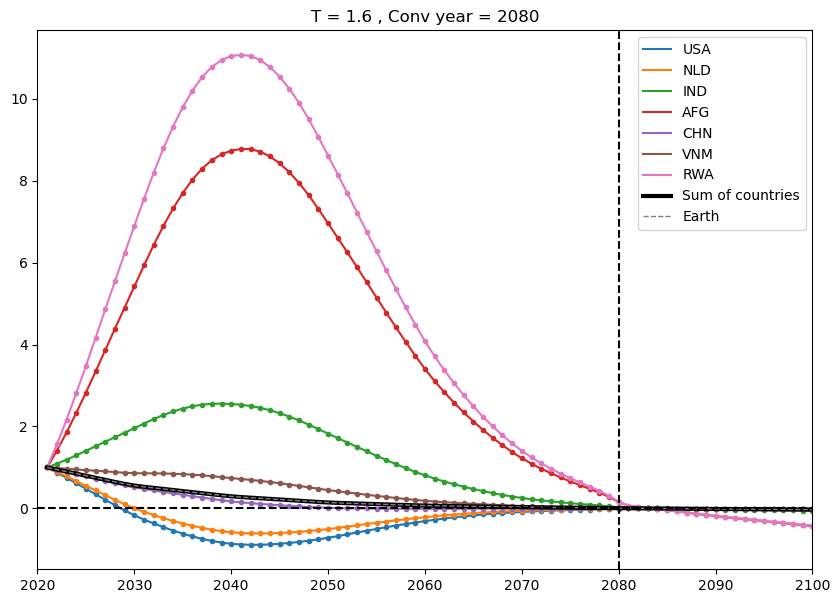

In [371]:
T = 1.6
fig, ax = plt.subplots(figsize=(10, 7))
for reg in ['USA', 'NLD', 'IND', 'AFG', 'CHN', 'VNM', 'RWA']:
    y, = plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=reg, Temperature=T) / xr_ecpc_alloc.sel(Region=reg, Time=2021, Temperature=T), label=reg)
    plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=reg, Temperature=T) / xr_ecpc_alloc.sel(Region=reg, Temperature=T, Time=2021), '.', c=y.get_color())
plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=self.countries_iso, Temperature=T).sum(dim='Region') / xr_ecpc_alloc.sel(Region=self.countries_iso, Temperature=T).sum(dim='Region').sel(Time=2021), label='Sum of countries', lw=3, color='black')
plt.plot(self.xr_total.Time, self.xr_total.GHG_globe.sel(Temperature=T, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate') / self.xr_total.GHG_globe.sel(Time=2021, Temperature=T, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate'), label='Earth', lw=1, color='grey', ls='--')
plt.plot([2020, 2100], [0, 0], 'k--')

# vertical line
plt.axvline(x=conv_year, color='black', linestyle='--')

plt.xlim([2020, 2100])
#plt.ylim([-2, 10])
plt.legend()
plt.title('T = '+str(T)+ " , Conv year = "+str(conv_year))

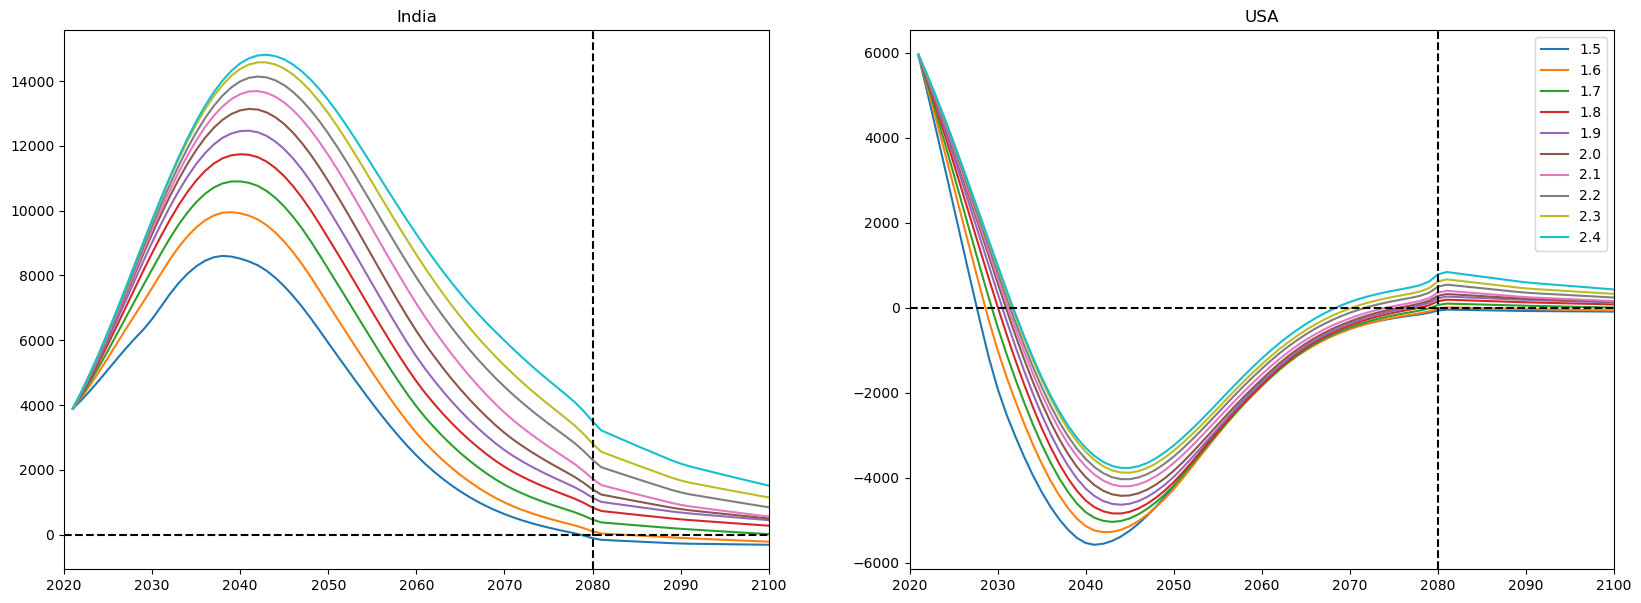

In [384]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 7))
reg = 'IND'
for T in xr_ecpc_alloc.Temperature:
    y, = ax.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=reg, Temperature=T), label=float(T))
    y, = ax2.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region='USA', Temperature=T), label=float(T))
#     plt.plot(xr_all2.Time, xr_all2.sel(Region=reg) / xr_all2.sel(Region=reg, Time=2021), '.', c=y.get_color())
# plt.plot(xr_all2.Time, xr_all2.sel(Region=self.countries_iso).sum(dim='Region') / xr_all2.sel(Region=self.countries_iso).sum(dim='Region').sel(Time=2021), label='Sum of countries', lw=3, color='black')
#plt.plot(self.xr_total.Time, self.xr_total.GHG_globe.sel(Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate') / self.xr_total.GHG_globe.sel(Time=2021, Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate'), label='Earth', lw=1, color='grey', ls='--')
ax.plot([2020, 2100], [0, 0], 'k--')
ax2.plot([2020, 2100], [0, 0], 'k--')

ax.set_xlim([2020, 2100])
ax2.set_xlim([2020, 2100])
ax.axvline(x=conv_year, color='black', linestyle='--')
ax2.axvline(x=conv_year, color='black', linestyle='--')
ax.set_title('India')
ax2.set_title('USA')
plt.legend()

Allocations specifically for Norway and Netherlands if you want to harmonize to national data

In [4]:
import class_allocation
reload(class_allocation)
from class_allocation import allocation

for lulucf in ['incl', 'excl']:
    for gas in ['GHG', 'CO2']:
        for dataread_file in ['xr_dataread.nc', 'xr_dataread_nor.nc']: # This is only necessary if for a country a specific historical emissions profile is required beyond what is in Jones (e.g. Norway was requested)
            allocator = allocation('NOR', lulucf=lulucf, gas=gas, dataread_file=dataread_file)
            allocator.gf()
            allocator.pc()
            allocator.pcc()
            allocator.pcb()
            allocator.ecpc()
            allocator.ap()
            allocator.gdr()
            allocator.save()
            print('NOR', lulucf, gas, dataread_file, 'done')

NOR incl GHG xr_dataread.nc done
NOR incl GHG xr_dataread_nor.nc done
NOR incl CO2 xr_dataread.nc done
NOR incl CO2 xr_dataread_nor.nc done
NOR excl GHG xr_dataread.nc done
NOR excl GHG xr_dataread_nor.nc done
NOR excl CO2 xr_dataread.nc done
NOR excl CO2 xr_dataread_nor.nc done


Allocation class

In [14]:
import class_allocation
reload(class_allocation)
from class_allocation import allocation

regions_iso = np.load("K:/Data/Data_effortsharing/DataUpdate_ongoing/all_regions.npy", allow_pickle=True)
for cty in tqdm(regions_iso):
    allocator = allocation(cty, lulucf='incl', gas='GHG')
    allocator.gf()
    allocator.pc()
    allocator.pcc()
    allocator.pcb()
    allocator.ecpc()
    allocator.ap()
    allocator.gdr()
    allocator.save()

100%|██████████| 207/207 [1:59:49<00:00, 34.73s/it]  


Allocation rules combining approaches (Robiou paper)

In [7]:
import class_allocation_combinedapproaches
reload(class_allocation_combinedapproaches)
from class_allocation_combinedapproaches import allocation_comb

allocator = allocation_comb(lulucf='excl', gas='GHG')
allocator.ecpc()
allocator.discounting_historical_emissions()
allocator.approach1gdp()
allocator.approach1hdi()
allocator.approach2()
allocator.approach2_transition()
allocator.combine()
allocator.get_relation_2030emis_temp()
allocator.determine_tempoutcomes()
allocator.save()

Temperature NDC-alignment metric

In [3]:
import class_tempalign
reload(class_tempalign)
from class_tempalign import tempaligning

tempaligner = tempaligning() # FIRST RUN AGGREGATOR FOR THIS!! (2030 alloc)
tempaligner.get_relation_2030emis_temp()
tempaligner.determine_tempoutcomes()
tempaligner.save()

# ==================================== #
# Initializing tempaligning class        #
# ==================================== #
- Determine relation between 2030-emissions and temperature outcome
- Determine temperature metric


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


- Save


Reading policy scenarios from ENGAGE

In [3]:
import class_policyscens
reload(class_policyscens)
from class_policyscens import policyscenadding

policyscenner = policyscenadding()
policyscenner.read_engage_data()
policyscenner.filter_and_convert()
policyscenner.add_to_xr()

# ==================================== #
# Initializing policyscenadding class  #
# ==================================== #
- Read ENGAGE scenarios and change region namings
- Filter correct scenarios and convert to xarray object
- Add to overall xrobject


Variance decomposition

In [7]:
import class_variancedecomp
reload(class_variancedecomp)
from class_variancedecomp import vardecomposing

vardecomposer = vardecomposing(startyear=2021, gas='GHG', lulucf='incl')
vardecomposer.sobolindices = {}
print('- Starting sobols for fixed years, over many countries')
timeseries = np.arange(2030, 2101, 5)
for year in timeseries:
    print('  Starting with', year)
    xr_cty, ar_time, array_dims, array_inputs, problem, samples = vardecomposer.prepare_global_sobol(year)
    vardecomposer.sobolindices[year] = vardecomposer.apply_decomposition(xr_cty, ar_time, array_dims, array_inputs, problem, samples)
vardecomposer.save(array_dims, timeseries)

# ==================================== #
# Initializing vardecomposing class    #
# ==================================== #
- Starting sobols for fixed years, over many countries
  Starting with 2030


207it [02:30,  1.38it/s]


  Starting with 2035


207it [02:19,  1.49it/s]


  Starting with 2040


207it [02:16,  1.52it/s]


  Starting with 2045


207it [02:12,  1.57it/s]


  Starting with 2050


207it [02:12,  1.56it/s]


  Starting with 2055


207it [02:14,  1.54it/s]


  Starting with 2060


207it [02:12,  1.56it/s]


  Starting with 2065


207it [02:10,  1.59it/s]


  Starting with 2070


207it [02:10,  1.59it/s]


  Starting with 2075


207it [02:09,  1.60it/s]


  Starting with 2080


207it [02:10,  1.59it/s]


  Starting with 2085


207it [02:14,  1.54it/s]


  Starting with 2090


207it [02:09,  1.60it/s]


  Starting with 2095


207it [02:09,  1.60it/s]


  Starting with 2100


207it [02:12,  1.56it/s]

- Save global results
